In [2]:
# Standard python numerical analysis imports:
import numpy as np
import random
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import pylab 
import time

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# All the pycbc module imports
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform
#from pycbc.waveform import generator
from pycbc.detector import Detector
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc import types, fft, waveform
import pycbc.noise
import pycbc.psd

make_plots = 1
plottype = "pdf"

plt.rcParams.update({'font.size': 18})

tt = time.time()

#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
# Prompt to test whether an eventname actually was specified
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()
    
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
    
# Both H1 and L1 have the same time vector, so we only need to define one time variable:
t = time_H1
# The time sample interval (uniformly sampled!)
dt = t[1] - t[2]

# Plotting a symmetrical period about the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((t >= tevent-deltat) & (t < tevent+deltat))

#POWER SPECTRAL DENSITY CREATION
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

# WHITEN THE DATA
dt = 1/4096
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    # Bandpass using a Butterworth filter
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

/local/environments/gw/gw-python/lib/python3.4/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/local/environments/gw/gw-python/lib/python3.4/site-packages/ipykernel_launcher.py:114: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


## Waveform Generation

Comment out the section that is wanted below, 
the order is:
1. Exponential Sine-Gaussian distribution
2. Gaussian distribution
3. Laplace Distribution
4. Gumbel Distribution

In [3]:
wavetype = 0

In [4]:
# GAUS EXP

'''
wavetype = 'Expgaus'

mu = 0 #Offset from centre
lamda = 4 # Rate of exponential component
sigma = 0.01 # Width constant for the distribution
expmult = 125 #Exp amplitude multiplier
freqmult = 500 #Sine frequency multiplier
sinemult = 5e-24 #Sine amplitude multiplier
yexp1 = []

xvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz


# Number of each variable to be generated
no_of_lamda=5     
no_of_sigma=5     
no_of_freq=5  
no_of_gamp=5

# Extracts a series from 0 to the number of each variable
lamda_range,sigma_range,freq_range,gamp_range = range(no_of_lamda),range(no_of_sigma),range(no_of_freq),range(no_of_gamp)

# Starting values of each variable
lamda_start=4
sigma_start=0.01
freq_start=250
gamp_start=2

# Size of intervals in the variables
lamda_step = lamda_start / 2
sigma_step = sigma_start / 2
freq_step = freq_start / 2
gamp_step = gamp_start / 2

l,s,e,g=[lamda_start + i*lamda_step for i in lamda_range],[sigma_start + i*sigma_step for i in sigma_range],[freq_start + i*freq_step for i in freq_range],[gamp_start + i*gamp_step for i in gamp_range]

# Logical indexing to allow for different manipulations of the xvals depending on their values
ltzero = xvals < 0   # Creates a list of the xvals that are less than 0
gtzero = xvals >= 0  # Creates a list of the xvals that are greater than or equal to 0

# Declaring the empty lists
values = []
yvals = []

for a,av in enumerate(l):
    for b,bv in enumerate(s):
        for c,cv in enumerate(e):
            for d,dv in enumerate(g):
                y=np.zeros(len(xvals))            
                y[ltzero] = expmult*av*np.exp(av*xvals[ltzero])  # Exponential growth for those values that fulfill this criteria  
                y[gtzero] = dv*(1/bv*(2*np.pi)**(1/2))*np.exp(-0.5*((xvals[gtzero]-mu)/bv)**2)  # Gaussian for values that fulfill the second criteria          
                ysine = sinemult*np.sin(cv*xvals)
                y=y*ysine
                yvals.append(y)
                val = av,bv,cv # Makes a variable with the variables that have been used
                values.append(val) # Creates a list of lists

#sg_plus_noise = yvals1+noise

print('Finished the Exponential Gaussian')

'''

"\nwavetype = 'Expgaus'\n\nmu = 0 #Offset from centre\nlamda = 4 # Rate of exponential component\nsigma = 0.01 # Width constant for the distribution\nexpmult = 125 #Exp amplitude multiplier\nfreqmult = 500 #Sine frequency multiplier\nsinemult = 5e-24 #Sine amplitude multiplier\nyexp1 = []\n\nxvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz\n\n\n# Number of each variable to be generated\nno_of_lamda=5     \nno_of_sigma=5     \nno_of_freq=5  \nno_of_gamp=5\n\n# Extracts a series from 0 to the number of each variable\nlamda_range,sigma_range,freq_range,gamp_range = range(no_of_lamda),range(no_of_sigma),range(no_of_freq),range(no_of_gamp)\n\n# Starting values of each variable\nlamda_start=4\nsigma_start=0.01\nfreq_start=250\ngamp_start=2\n\n# Size of intervals in the variables\nlamda_step = lamda_start / 2\nsigma_step = sigma_start / 2\nfreq_step = freq_start / 2\ngamp_step = gamp_start / 2\n\nl,s,e,g=[lamda_start + i*lamda_step for i in lamda_range],[sigma_s

In [5]:
# GAUS

#'''

wavetype = 'gaus'

mu = 0 #Offset from centre
sigma = 0.01 # Width constant for the distribution
freqmult = 500 #Sine frequency multiplier
sinemult = 5e-24 #Sine amplitude multiplier

xvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz

# Number of each variable to be generated
no_of_gamp=6     
no_of_sigma=6     
no_of_freq=6   

# Extracts a series from 0 to the number of each variable
gamp_range,sigma_range,freq_range = range(no_of_gamp),range(no_of_sigma),range(no_of_freq)

# Starting values of each variable
gamp_start=2
sigma_start=0.01
freq_start=250

# Size of intervals in the variables
gamp_step = gamp_start / 2
sigma_step = sigma_start / 2
freq_step = freq_start / 2

g,s,e=[gamp_start + i*gamp_step for i in gamp_range],[sigma_start + i*sigma_step for i in sigma_range],[freq_start + i*freq_step for i in freq_range]

# Declaring the empty lists
values = []
yvals = []

for a,av in enumerate(g):
    for b,bv in enumerate(s):
        for c,cv in enumerate(e):
            y=np.zeros(len(xvals))  
            y = av*(1/bv*(2*np.pi)**(1/2))*np.exp(-0.5*((xvals-mu)/bv)**2)  # Gaussian          
            ysine = sinemult*np.sin(cv*xvals)
            y=y*ysine
            yvals.append(y)
            val = av,bv,cv # Makes a variable with the variables that have been used
            values.append(val) # Creates a list of lists

#sg_plus_noise = yvals1+noise

print('Finished gauss')


#'''

Finished gauss


In [6]:
#LAPLACE

#'''

wavetype = 'Laplace'

mu = 0 #Offset from centre
sigma = 0.01 # Width constant for the distribution (sharpness)
freqmult = 500 #Sine frequency multiplier
sinemult = 5e-24 #Sine amplitude multiplier

xvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz

# Number of each variable to be generated
no_of_gamp=6     
no_of_sigma=6     
no_of_freq=6   

# Extracts a series from 0 to the number of each variable
gamp_range,sigma_range,freq_range = range(no_of_gamp),range(no_of_sigma),range(no_of_freq)

# Starting values of each variable
gamp_start=15
sigma_start=0.01
freq_start=250

# Size of intervals in the variables
gamp_step = gamp_start / 2
sigma_step = sigma_start / 2
freq_step = freq_start / 2

g,s,e=[gamp_start + i*gamp_step for i in gamp_range],[sigma_start + i*sigma_step for i in sigma_range],[freq_start + i*freq_step for i in freq_range]

# Declaring the empty lists
values = []
yvals = []

for a,av in enumerate(g):
    for b,bv in enumerate(s):
        for c,cv in enumerate(e):
            y=np.zeros(len(xvals))  
            y = av*(1/(2*bv)*np.exp(-((np.absolute(xvals-mu))/bv))) # Laplace         
            ysine = sinemult*np.sin(cv*xvals)
            y=y*ysine
            yvals.append(y)
            val = av,bv,cv # Makes a variable with the variables that have been used
            values.append(val) # Creates a list of lists

#sg_plus_noise = yvals1+noise

print('Finished Laplace')
with open('laplace_'+wavetype+'_'+eventname+'.txt','w') as f:
    for i in values:
        
        f.write(str(i) + '\n')
#'''

Finished Laplace


In [7]:
#GUMBEL
'''

wavetype = 'Gumbel'

mu = 0 #Offset from centre
sigma = 0.01 # Width constant for the distribution (sharpness)
freqmult = 500 #Sine frequency multiplier
sinemult = 5e-24 #Sine amplitude multiplier

xvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz

# Number of each variable to be generated
no_of_gamp=6    
no_of_sigma=6     
no_of_freq=6   

# Extracts a series from 0 to the number of each variable
gamp_range,sigma_range,freq_range = range(no_of_gamp),range(no_of_sigma),range(no_of_freq)

# Starting values of each variable
gamp_start=15
sigma_start=0.01
freq_start=250

# Size of intervals in the variables
gamp_step = gamp_start / 2
sigma_step = sigma_start / 2
freq_step = freq_start / 2

g,s,e=[gamp_start + i*gamp_step for i in gamp_range],[sigma_start + i*sigma_step for i in sigma_range],[freq_start + i*freq_step for i in freq_range]

# Declaring the empty lists
values = []
yvals = []

for a,av in enumerate(g):
    for b,bv in enumerate(s):
        for c,cv in enumerate(e):
            y=np.zeros(len(xvals))  
            y = av*((1/bv)*np.exp(-(((-xvals-mu)/bv)+np.exp(-((-xvals-mu)/bv))))) # Gumbel         
            ysine = sinemult*np.sin(cv*xvals)
            y=y*ysine
            yvals.append(y)
            val = av,bv,cv # Makes a variable with the variables that have been used
            values.append(val) # Creates a list of lists

#sg_plus_noise = yvals1+noise

print('Finished Gumbel')

'''

"\n\nwavetype = 'Gumbel'\n\nmu = 0 #Offset from centre\nsigma = 0.01 # Width constant for the distribution (sharpness)\nfreqmult = 500 #Sine frequency multiplier\nsinemult = 5e-24 #Sine amplitude multiplier\n\nxvals = np.linspace(-16,16,4096*32)    # Generates a 32 long x series of 4096Hz\n\n# Number of each variable to be generated\nno_of_gamp=6    \nno_of_sigma=6     \nno_of_freq=6   \n\n# Extracts a series from 0 to the number of each variable\ngamp_range,sigma_range,freq_range = range(no_of_gamp),range(no_of_sigma),range(no_of_freq)\n\n# Starting values of each variable\ngamp_start=15\nsigma_start=0.01\nfreq_start=250\n\n# Size of intervals in the variables\ngamp_step = gamp_start / 2\nsigma_step = sigma_start / 2\nfreq_step = freq_start / 2\n\ng,s,e=[gamp_start + i*gamp_step for i in gamp_range],[sigma_start + i*sigma_step for i in sigma_range],[freq_start + i*freq_step for i in freq_range]\n\n# Declaring the empty lists\nvalues = []\nyvals = []\n\nfor a,av in enumerate(g):\n    f

In [8]:
if wavetype == 0:
    print('Need to select a wavetype')
else:
    print(wavetype)

Laplace


In [9]:
t2 = time.time()

NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

wave_info = []
yvals = np.array(yvals)

for i in range(len(yvals)):
    template = yvals[i] #WAVEFORM FROM LOOP

    # the length and sampling rate of the template MUST match that of the data.
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])
    
    # to remove effects at the beginning and end of the data stretch, window the data
    # https://en.wikipedia.org/wiki/Window_function#Tukey_window
    try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
    except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available
    
    # prepare the template fft.
    template_fft = np.fft.fft(template*dwindow) / fs
    
    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
    
        if det is 'L1': data = strain_L1.copy()
        else:           data = strain_H1.copy()
    
        # -- Calculate the PSD of the data.  Also use an overlap, and window:
        data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    
        # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
        data_fft = np.fft.fft(data*dwindow) / fs
    
        # -- Interpolate to get the PSD values at the needed frequencies
        power_vec = np.interp(np.abs(datafreq), freqs, data_psd)
    
        # -- Calculate the matched filter output in the time domain:
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
        # so the result will be plotted as a function of time off-set between the template and the data:
        optimal = data_fft * template_fft.conjugate() / power_vec
        optimal_time = 2*np.fft.ifft(optimal)*fs
    
        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time/sigma
    
        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data.size / 2)  # location of peak in the template
        SNR_complex = np.roll(SNR_complex,peaksample)
        SNR = abs(SNR_complex)
    
        # find the time and SNR value at maximum:
        indmax = np.argmax(SNR)
        timemax = t[indmax]
        SNRmax = SNR[indmax]
    
        # Calculate the "effective distance" (see FINDCHIRP paper for definition)
        # d_eff = (8. / SNRmax)*D_thresh
        d_eff = sigma / SNRmax
        # -- Calculate optimal horizon distnace
        horizon = sigma/8
    
        # Extract time offset and phase at peak
        phase = np.angle(SNR_complex[indmax])
        offset = (indmax-peaksample)
    
        # apply time offset, phase, and d_eff to template 
        template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
        template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
        
        # Whiten and band-pass the template for plotting
        template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
        template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template        
       
        # plotting changes for the detectors:
        if det is 'L1':
            strain_whitenbp = strain_L1_whitenbp
        else:
            strain_whitenbp = strain_H1_whitenbp
                   
        # Calculating the correlation of the template and the data
        template_match = template_match[60000:70000]
        strain_whitenbp = strain_whitenbp[60000:70000]
        corre = np.correlate(strain_whitenbp, template_match)   # Non-normalised correlation function
        denom = np.sqrt(sum(strain_whitenbp**2)*sum(template_match**2))   # Denominator for scaling the correlation coefficient
        normcor = corre/denom  # Normalises the correlation coefficient

        #print('Normalised correlation coefficient',normcor)

        # Calculating a value for the residual using abosulte values

        resid = strain_whitenbp - template_match   # Creates the residual data
        absresid = []   
        for j in resid:
            absresid.append(abs(j))   # Takes the absolute value of the ith number and appends it to the empty list
        residco = sum(absresid)   # Sums up the absolute values of the residual plot to give a metric for the quality of the match
        
        #print('Sum of the absolute values of the residual', residco)
        normcor = float(normcor)
        wave_info.append([i,det,normcor,residco])
        
elapsed = time.time() - t2
print('finished',elapsed)

/local/environments/gw/gw-python/lib/python3.4/site-packages/ipykernel_launcher.py:114: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


finished 55.51900792121887


In [10]:
with open('wave_info_full_'+wavetype+'_'+eventname+'.txt','w') as f:
    for i in wave_info:
        
        f.write(str(i) + '\n')

In [11]:
corrmax=wave_info[0]
residmax=wave_info[0]
corrmin=wave_info[0]
residmin=wave_info[0]


for i in wave_info:
    corr = i[2]
    resid = i[3]
    
    if corr > corrmax[2]: # This is the best correlation, the closer to 1 the better
        corrmax = i
    
    if corr < corrmin[2]: # This is the worst correlation
        corrmin = i

        
    if resid > residmax[3]: # This is the worst residual
        residmax = i

    
    if resid < residmin[3]: # This is the best residual, the closer to 0 the better
        residmin = i


[113, 'H1', 0.27251512399953315, 8307.529859600954]


/local/environments/gw/gw-python/lib/python3.4/site-packages/ipykernel_launcher.py:114: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/local/environments/gw/gw-python/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[214, 'L1', 0.0036501190141052333, 8028.9257883122455]
[141, 'H1', 0.18579663606798094, 8388.412026600727]
[109, 'L1', 0.15404082425438134, 7951.833336844152]


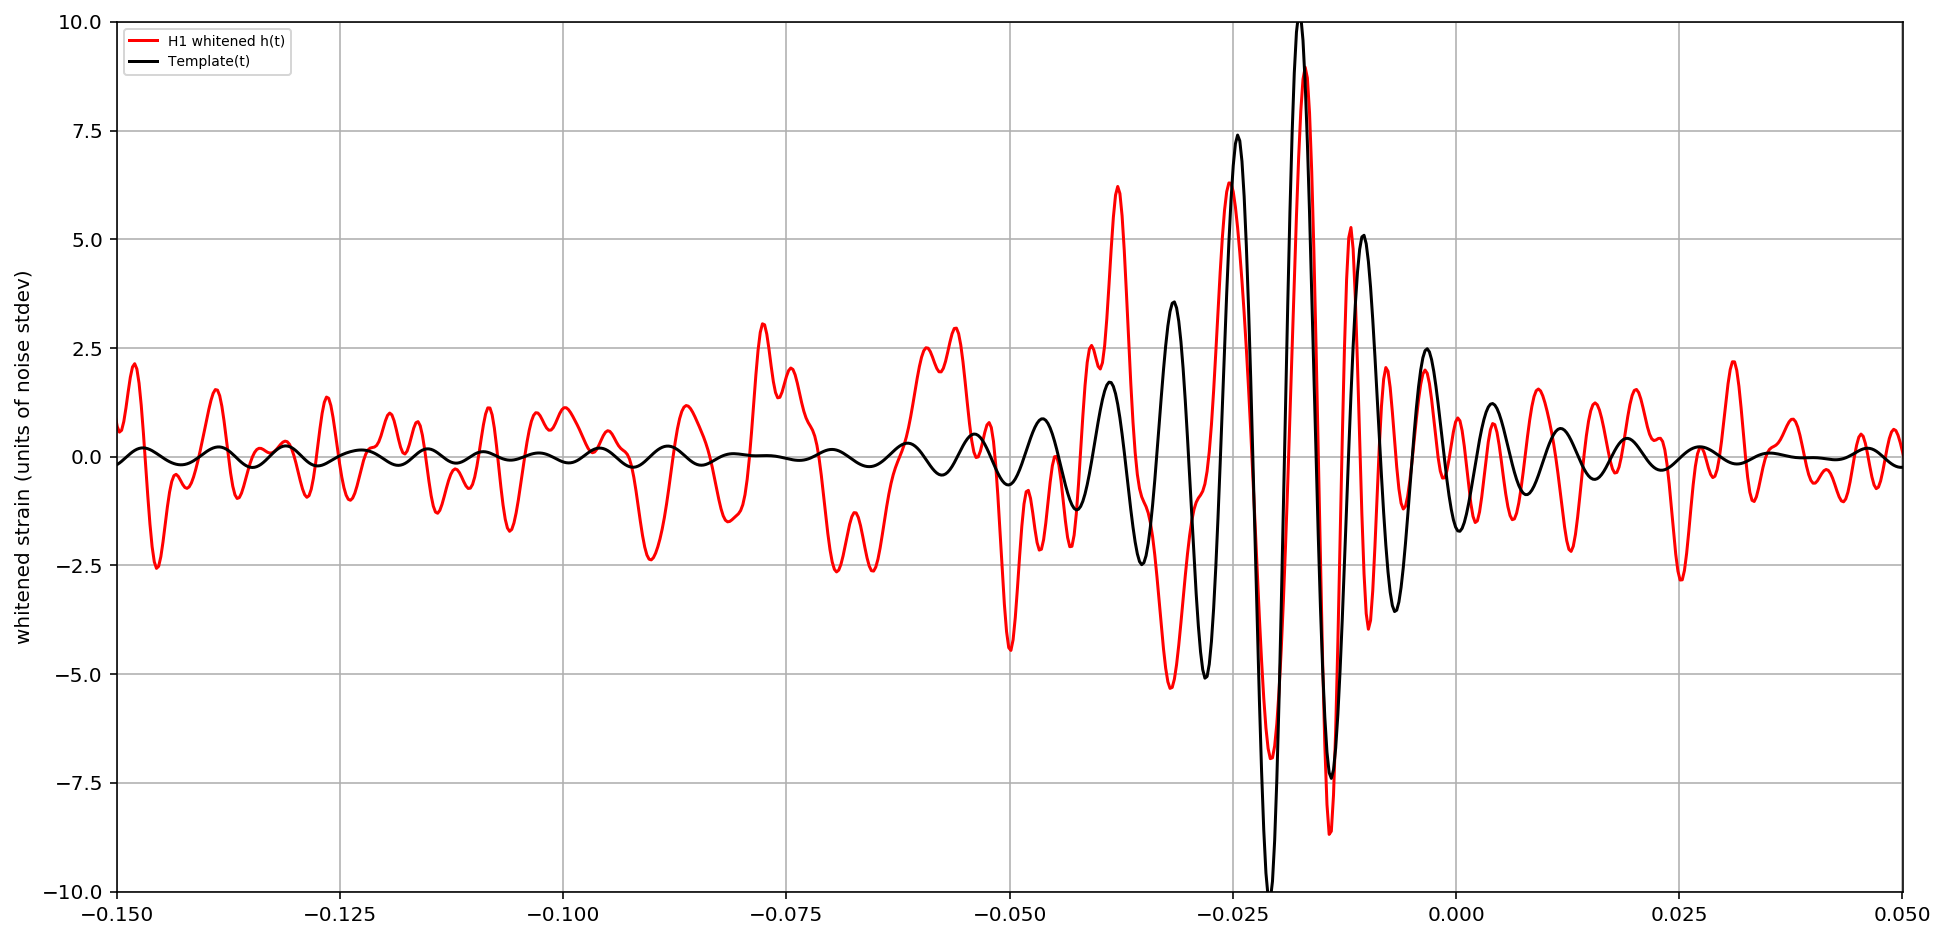

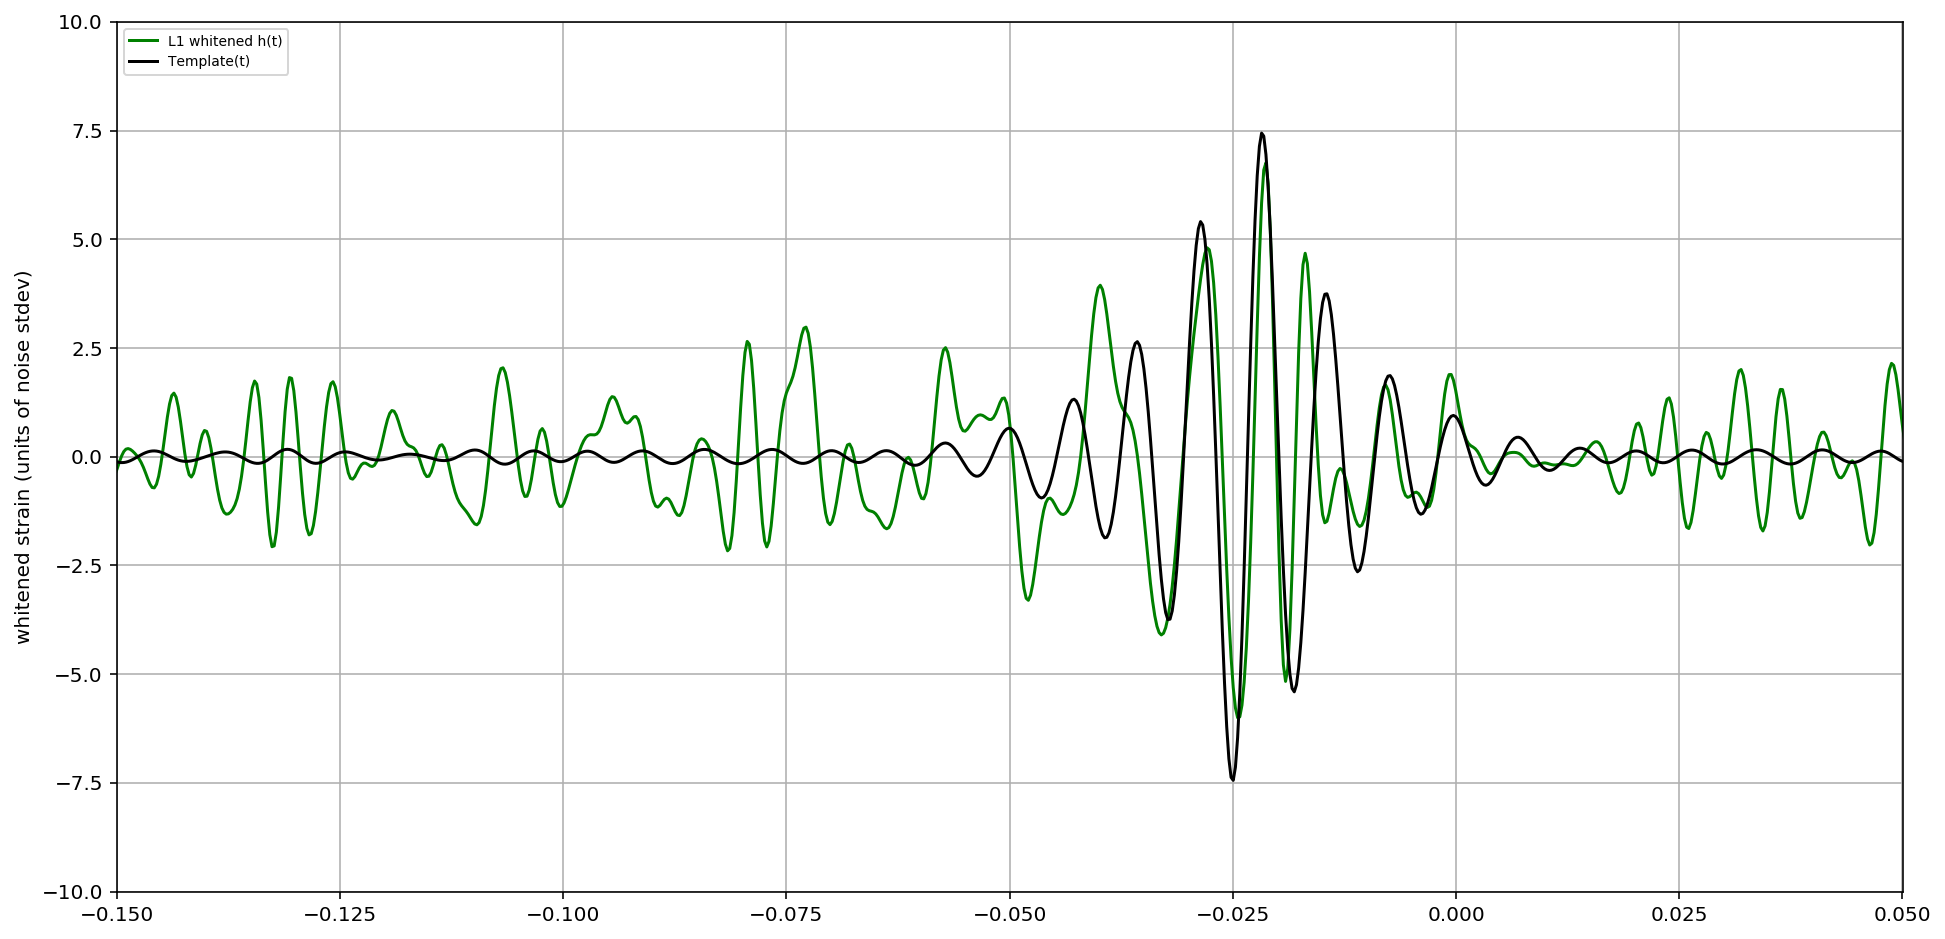

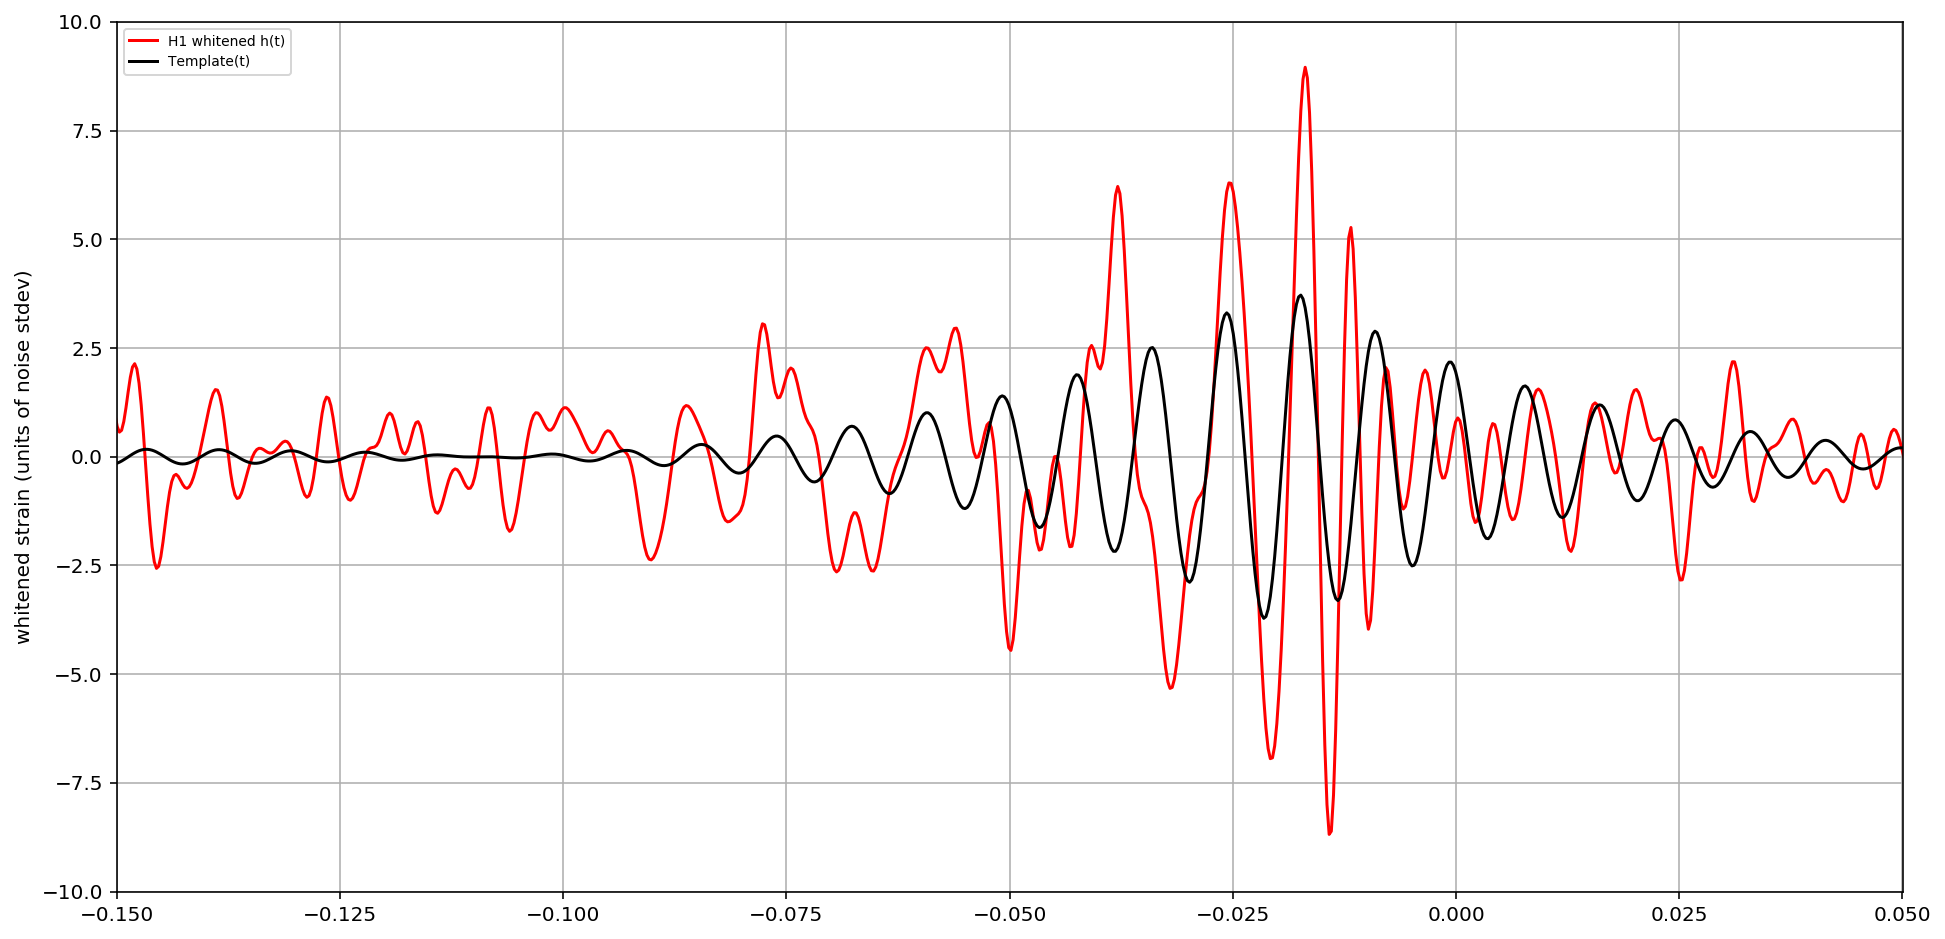

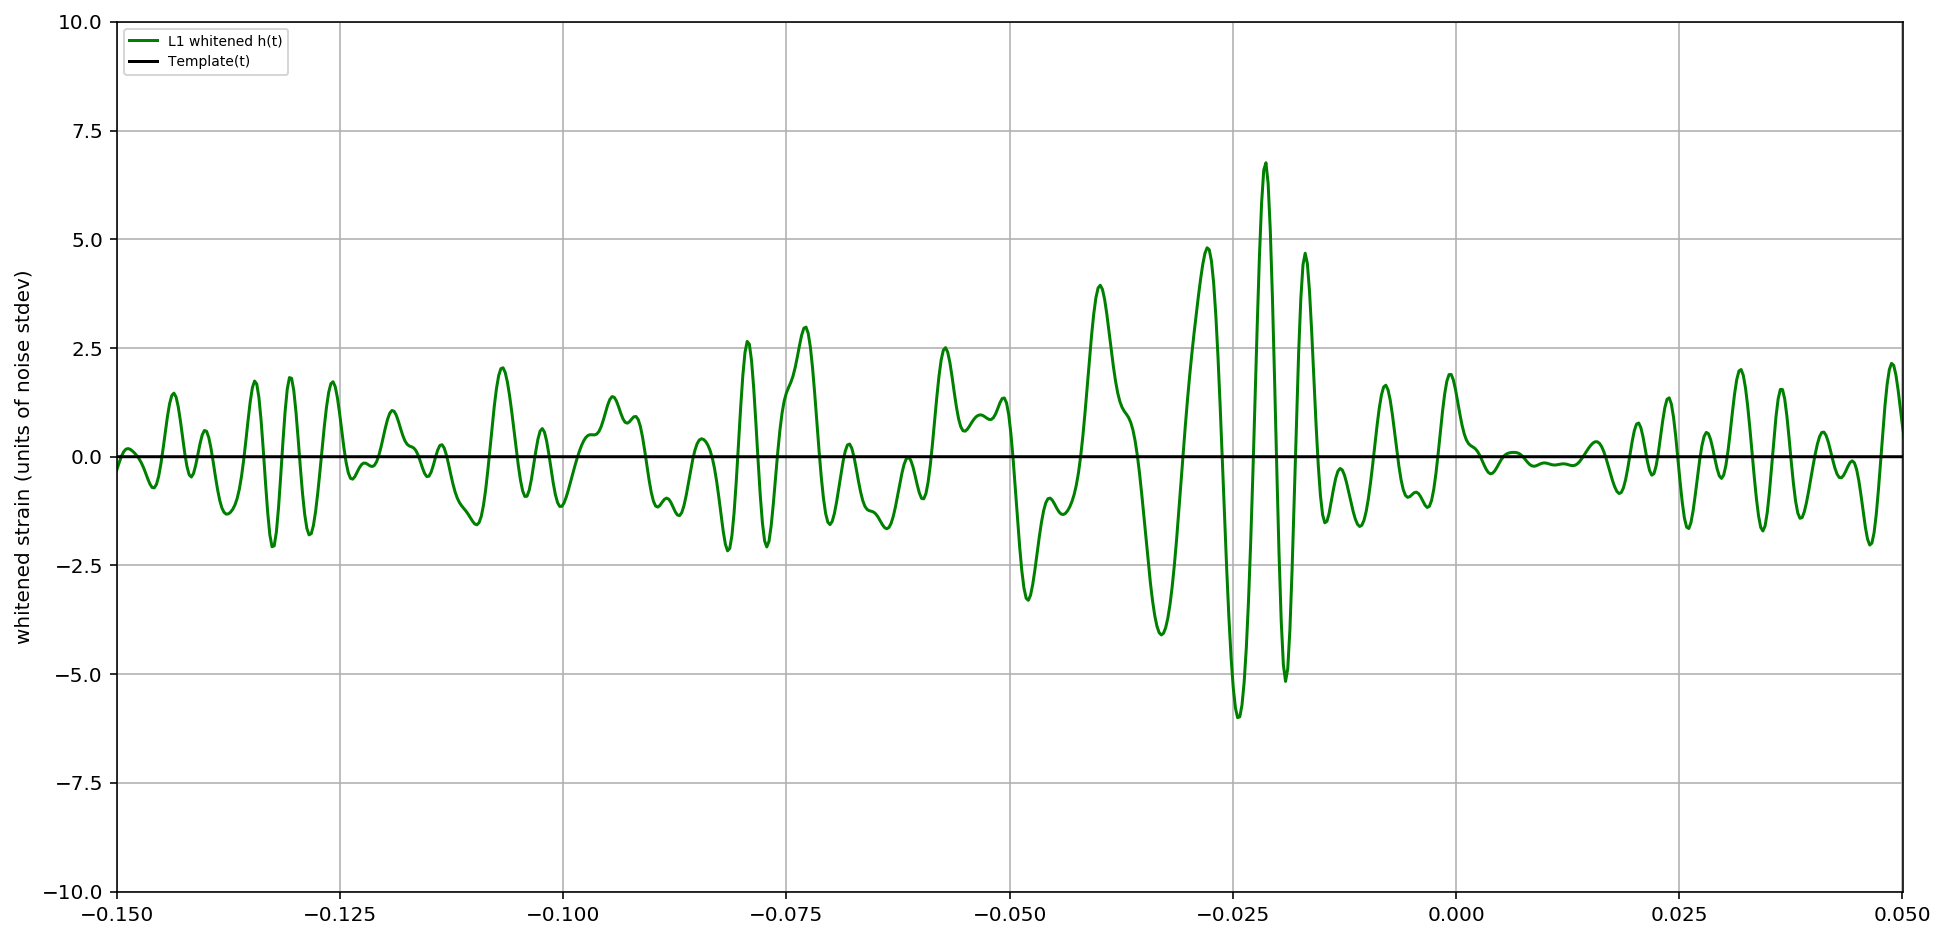

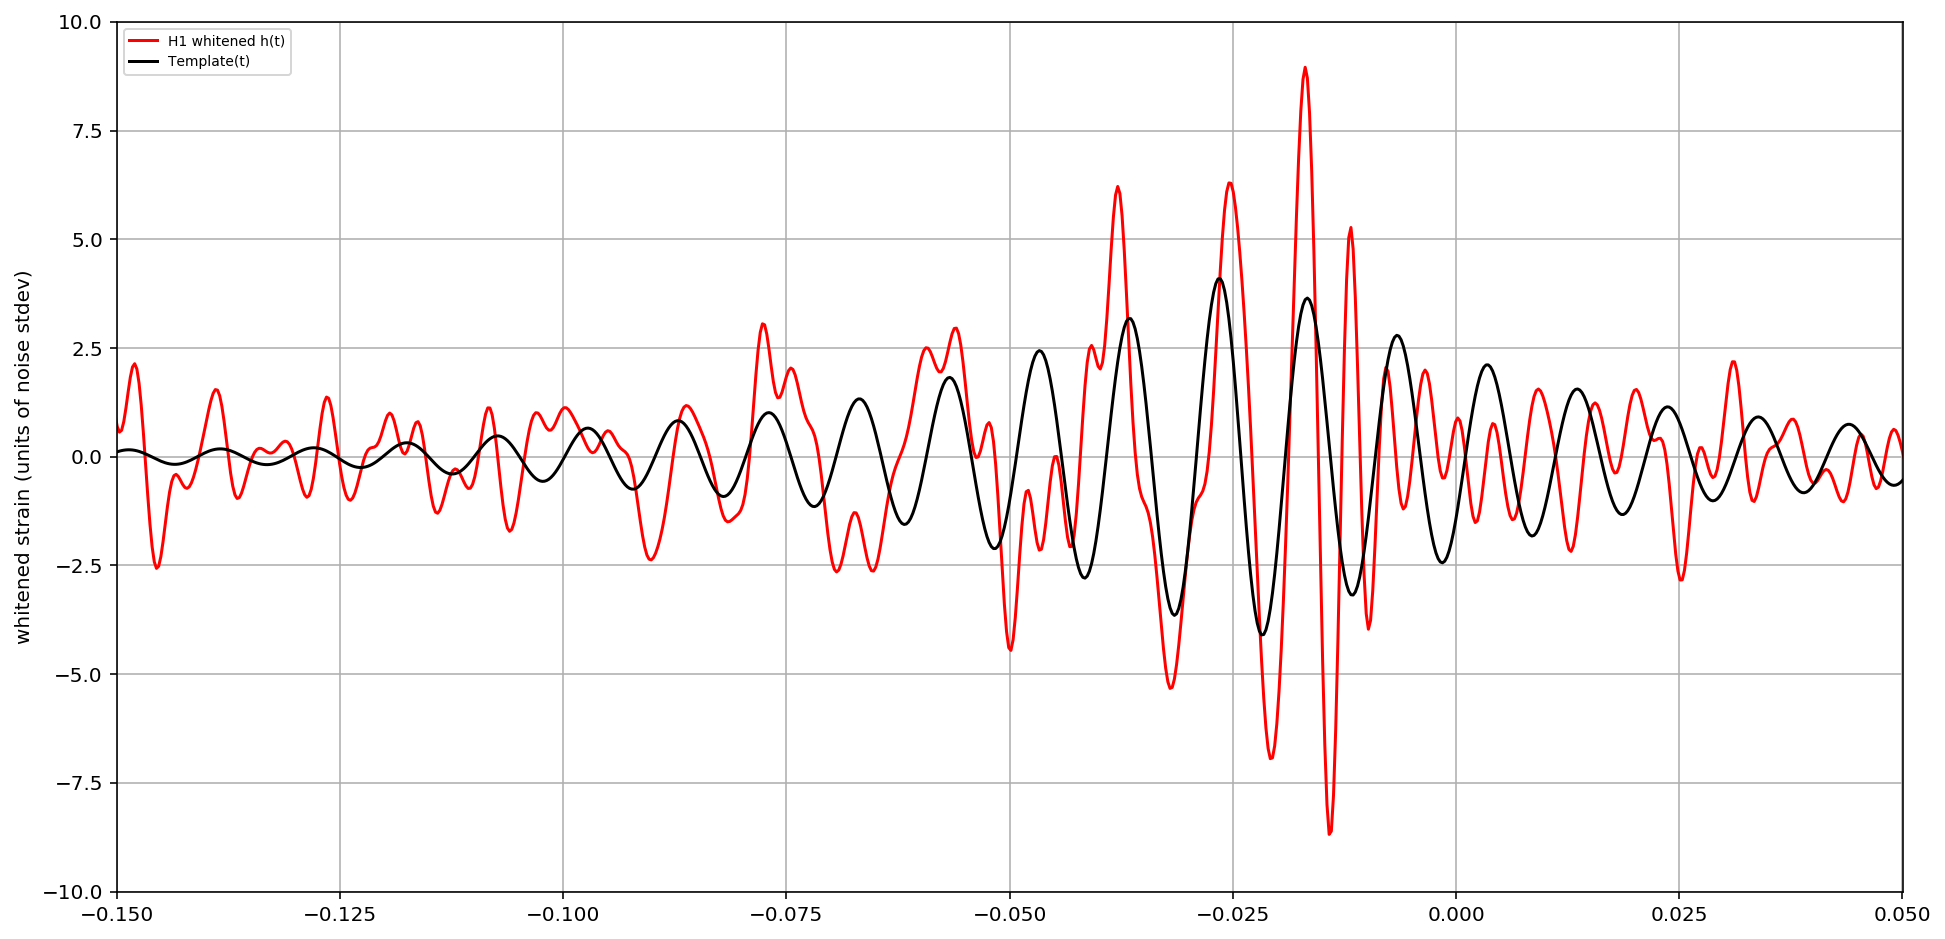

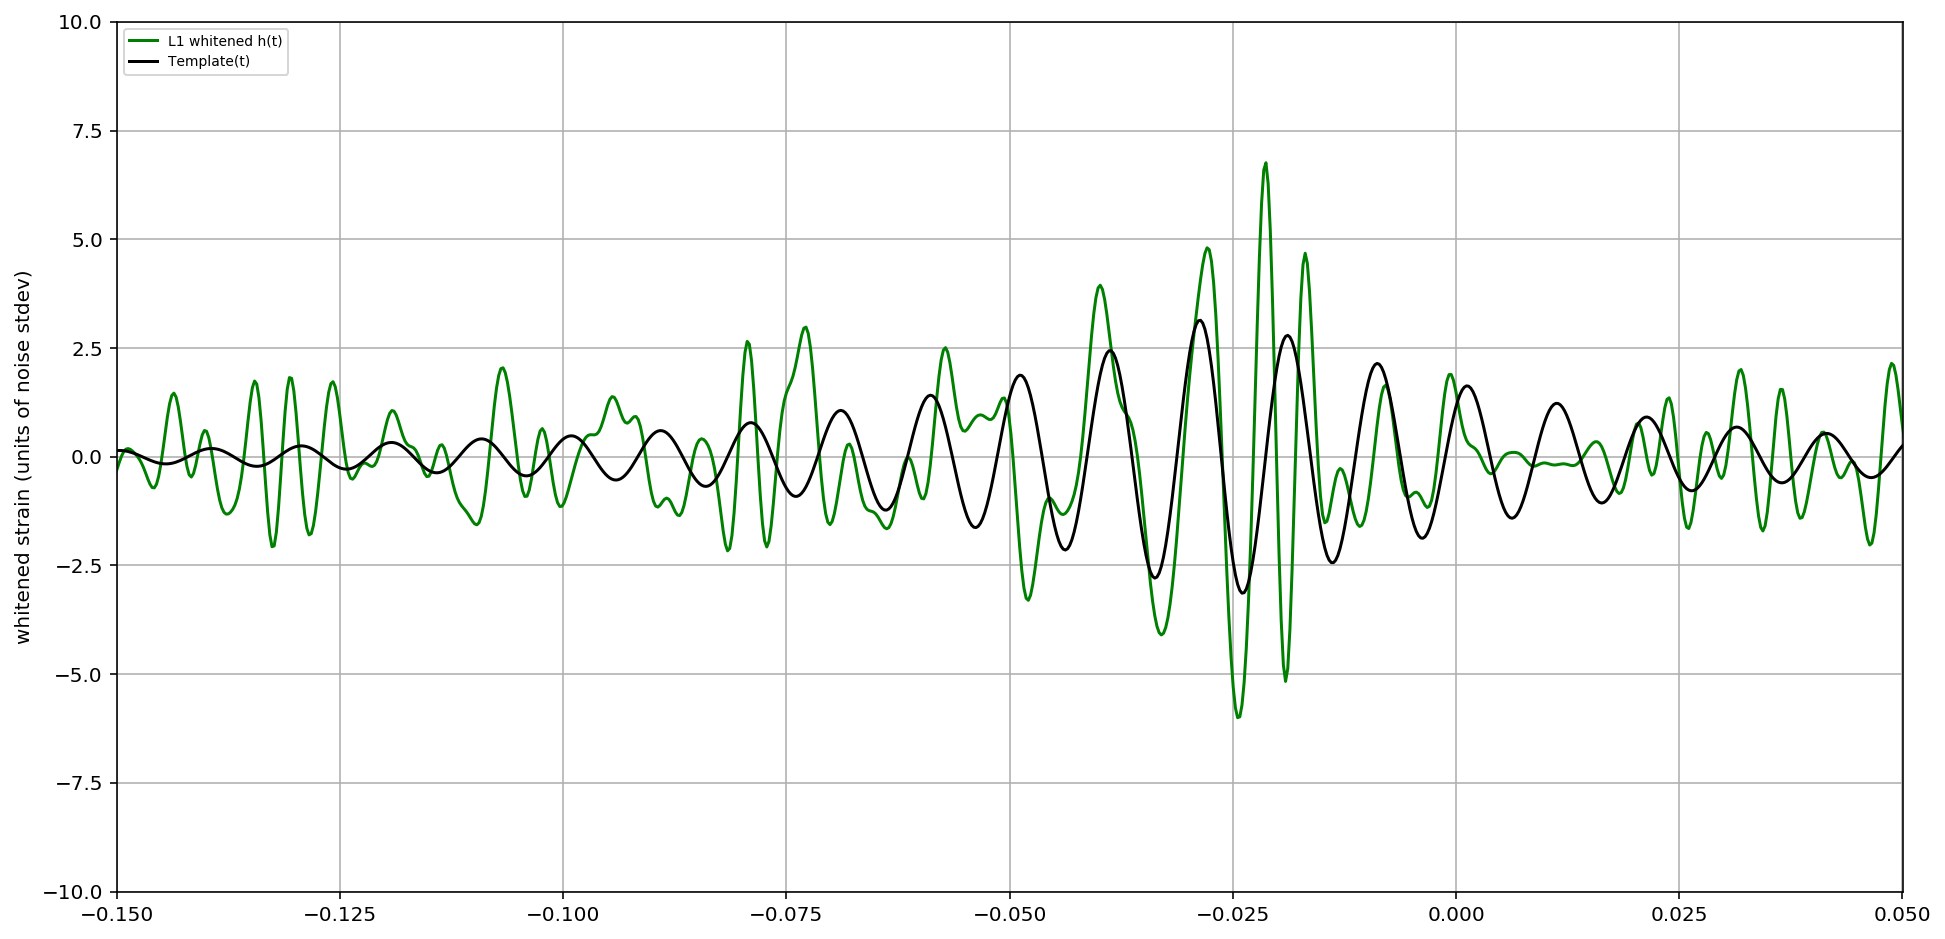

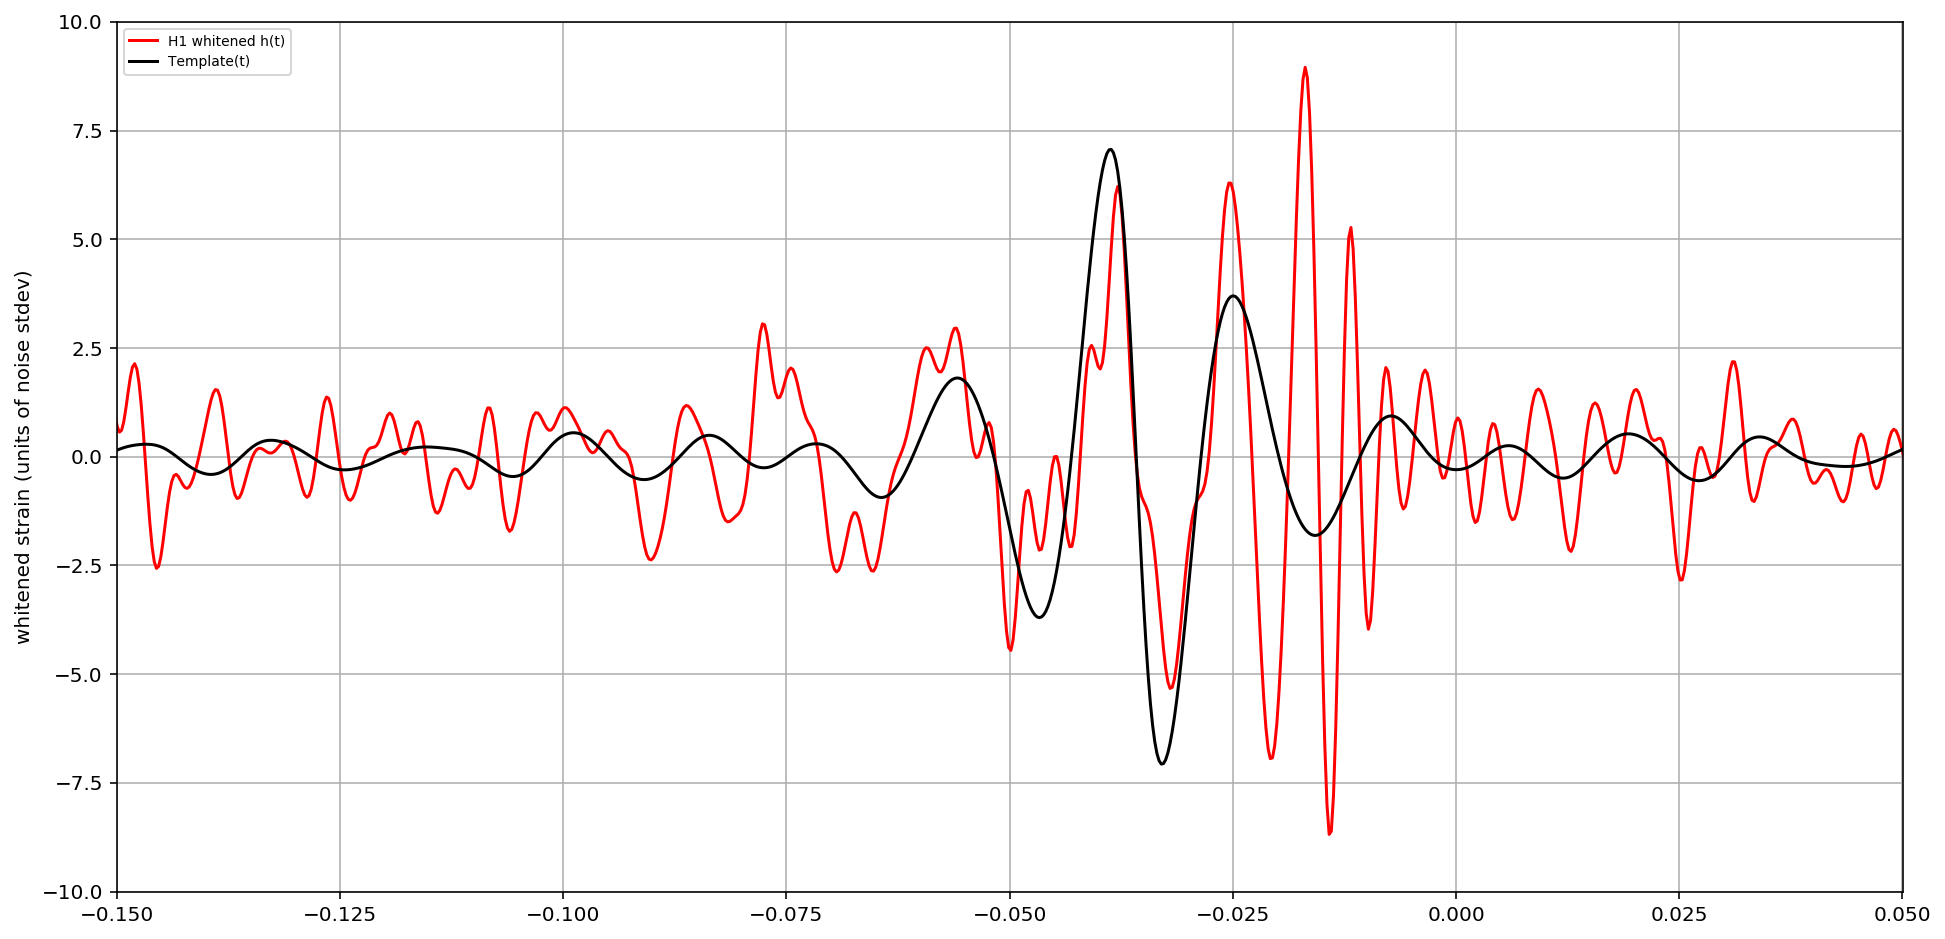

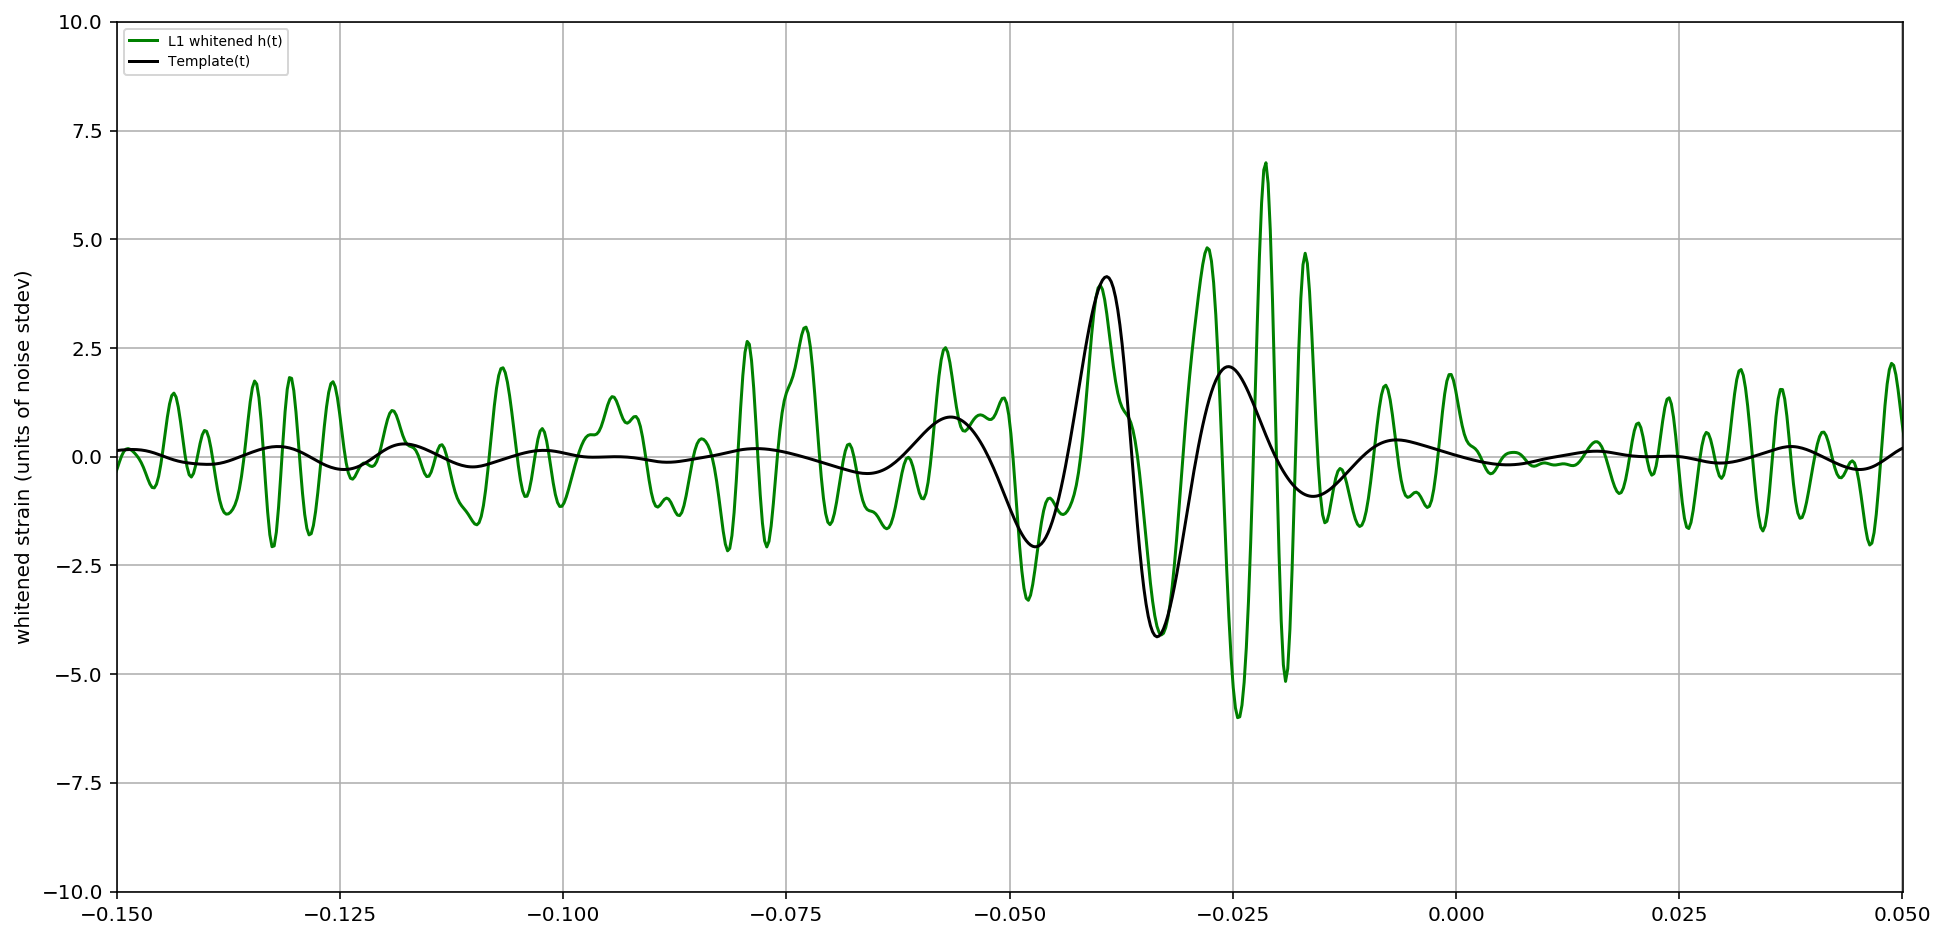

In [12]:
make_plots = 1

print(corrmax)
template = yvals[corrmax[0]] #WAVEFORM FROM LOOP

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = t[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(16,8))
        '''
        plt.subplot(2,1,1)
        plt.plot(t-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',corrmax[2]))
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',corrmax[3]))
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' matched filter SNR around event for waveform no.'+str(corrmax[0]))
      
        plt.subplot(2,1,2)
        '''
        plt.plot(t-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(t-tevent,template_match,'k',label='Template(t)')
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',corrmax[2]))
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',corrmax[3]))
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' whitened data around event for waveform no.'+str(corrmax[0]))
        plt.savefig(eventname+"_"+det+"_"+wavetype+"_maxcorr."+plottype, bbox_inches='tight')
        

print(corrmin)
template = yvals[corrmin[0]] #WAVEFORM FROM LOOP

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = t[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()


        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(16,8))
        '''
        plt.subplot(2,1,1)
        plt.plot(t-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',corrmin[2]))
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',corrmin[3]))
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' matched filter SNR around event for waveform no.'+str(corrmin[0]))
      
        plt.subplot(2,1,2)
        '''
        plt.plot(t-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(t-tevent,template_match,'k',label='Template(t)')
       # plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',corrmin[2]))
       # plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',corrmin[3]))
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' whitened data around event for waveform no.'+str(corrmin[0]))
        plt.savefig(eventname+"_"+det+"_"+wavetype+"_mincorr."+plottype, bbox_inches='tight')
        
print(residmax)
template = yvals[residmax[0]] #WAVEFORM FROM LOOP

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = t[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        
        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(16,8))
        '''        plt.subplot(2,1,1)
        plt.plot(t-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',residmax[2]))
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',residmax[3]))
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' matched filter SNR around event for waveform no.'+str(residmax[0]))
      
        plt.subplot(2,1,2)
        '''
        plt.plot(t-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(t-tevent,template_match,'k',label='Template(t)')
     #   plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',residmax[2]))
      #  plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',residmax[3]))
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' whitened data around event for waveform no.'+str(residmax[0]))
        plt.savefig(eventname+"_"+det+"_"+wavetype+"_maxresid."+plottype, bbox_inches='tight')
        
        
print(residmin)
template = yvals[residmin[0]] #WAVEFORM FROM LOOP

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det is 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = t[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    if make_plots:

        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

       
        # plotting changes for the detectors:
        if det is 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(16,8))
        '''
        plt.subplot(2,1,1)
        plt.plot(t-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',residmin[2]))
        #plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',residmin[3]))
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' matched filter SNR around event for waveform no.'+str(residmin[0]))
      
        plt.subplot(2,1,2)
        '''
        plt.plot(t-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(t-tevent,template_match,'k',label='Template(t)')
       # plt.plot(np.NaN, np.NaN, '-', color='none',label=('Normalised correlation',residmin[2]))
       # plt.plot(np.NaN, np.NaN, '-', color='none',label=('Residual sum',residmin[3]))
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left',fontsize = 'x-small')
        #plt.title(det+' whitened data around event for waveform no.'+str(residmin[0]))
        plt.savefig(eventname+"_"+det+"_"+wavetype+"_minresid."+plottype, bbox_inches='tight')

In [13]:
info = [corrmax,corrmin,residmax,residmin]
header = ['corrmax','corrmin','residmax','residmin']

counter = 0
with open('wave_info_'+wavetype+'_'+eventname+'.txt','w') as f:
    for i in info:
        
        f.write(header[counter] + '\n' + str(i) + '\n')
        counter += 1

In [14]:
totelapsed = time.time()-tt
print('Total time taken', totelapsed)

Total time taken 87.67492032051086
